In [58]:
# setup our environment

import pandas as pd
import numpy as np

DATA_FILE = "data/fake_or_real_news.csv"

TEST_SIZE = 0.2
N_SAMPLE = 2000 # we only use N_SAMPLE news stories

# configure bootstrap
N_ITERATIONS = 50
ALPHA = .95

In [2]:
# define a function that allows us to evaluate our models

from sklearn.metrics import accuracy_score

def evaluate_model(predict_fun, X_train, y_train, X_test, y_test):
    '''
    evaluate the model, both training and testing errors are reported
    '''
    # training error
    y_predict_train = predict_fun(X_train)
    print("Training Accuracy: {: 6.2f}%".format(accuracy_score(y_train,y_predict_train)*100))
    # testing error
    y_predict_test = predict_fun(X_test)
    print("Testing Accuracy: {: 6.2f}%".format(accuracy_score(y_test,y_predict_test)*100))

In [60]:
# bootstrap function

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def bootstrap_conf(fit_fun, predict_fun, data, target_label, n_iterations, alpha):
    # compute the bootstrap samples
    stats = []
    print('Computing bootstrap samples: ', end='')
    for i in range(n_iterations):
        print(i, end=' ')
        # prepare train and test sets
        boot_sample = data.sample(n=data.shape[0],
                                  replace=True,
                                  axis='index')
        boot_X = boot_sample.drop(labels=target_label, axis='columns')
        boot_y = boot_sample[target_label]
        boot_X_train, boot_X_test, boot_y_train, boot_y_test = train_test_split(boot_X, 
                                                                                boot_y, 
                                                                                test_size=TEST_SIZE)
        # build & eval the model
        fit_fun(boot_X_train, boot_y_train)
        predictions = predict_fun(boot_X_test)
        score = accuracy_score(boot_y_test, predictions)
        # save the score for this bootstrap sample
        stats.append(score)
    print('')
    # confidence intervals
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(stats, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(stats, p))
    # average performance
    avg_acc = sum(stats)/n_iterations

    return lower, upper, avg_acc, stats

In [4]:
# read in our data and clean it
# NOTE: the data file contains empty 'text' entries

df = pd.read_csv(DATA_FILE)
df.drop(labels=['id','title'], axis='columns', inplace=True)

def drop_empty_rows(df):
    drop_list = []
    for i in range(df.shape[0]):
        if df.loc[i,'text'].isspace():
            print("found empty text @ {}...dropping".format(i))
            drop_list.append(i)
    new_df = df.drop(labels=drop_list, axis='index')
    new_index = [i for i in range(new_df.shape[0])]
    new_df.index = new_index
    return new_df

df = drop_empty_rows(df)

found empty text @ 106...dropping
found empty text @ 710...dropping
found empty text @ 806...dropping
found empty text @ 919...dropping
found empty text @ 940...dropping
found empty text @ 1664...dropping
found empty text @ 1736...dropping
found empty text @ 1851...dropping
found empty text @ 1883...dropping
found empty text @ 1941...dropping
found empty text @ 2244...dropping
found empty text @ 2426...dropping
found empty text @ 2576...dropping
found empty text @ 2662...dropping
found empty text @ 2788...dropping
found empty text @ 2832...dropping
found empty text @ 3073...dropping
found empty text @ 3350...dropping
found empty text @ 3511...dropping
found empty text @ 3641...dropping
found empty text @ 3642...dropping
found empty text @ 4014...dropping
found empty text @ 4142...dropping
found empty text @ 4253...dropping
found empty text @ 4713...dropping
found empty text @ 4744...dropping
found empty text @ 5017...dropping
found empty text @ 5088...dropping
found empty text @ 5213..

In [5]:
print(df.shape)

(6299, 2)


In [6]:
# sample down our data set

df = df.sample(n=N_SAMPLE, axis='index')

X = df['text']
y = df['label']

In [7]:
# convert labels to numeric labels
# NOTE: DNNs need numeric labels

def convert(x):
    if x == 'FAKE':
        return 0.0
    else:
        return 1.0


## Syntactic Features

In [9]:
# set up vector models for training and testing

from sklearn.feature_extraction.text import CountVectorizer

# data vectorizer
vectorizer = CountVectorizer(analyzer = "word", 
                             binary = True, 
                             min_df = 2,
                             stop_words='english')
docarray = vectorizer.fit_transform(X).toarray()
docterm = pd.DataFrame(docarray, columns=vectorizer.get_feature_names())

In [10]:
print(docterm.shape)

(2000, 23577)


In [55]:
# create training and test data
from sklearn.model_selection import train_test_split
docterm_train, docterm_test, y_train, y_test = train_test_split(docterm, y, test_size=TEST_SIZE)

In [49]:
# data for accuracy confidence interval and average accuracy

data = docterm.copy()
data['_label_'] = y.values

# dnn data has to be all numerical
dnn_data = docterm.copy()
dnn_data['_label_'] = y.apply(convert).values

In [56]:
# Naive Bayes Model - train & test
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(docterm_train, y_train)

# evaluate model
evaluate_model(model.predict, docterm_train, y_train, docterm_test, y_test)

Training Accuracy:  96.81%
Testing Accuracy:  84.00%


In [61]:
# Naive Bayes Model - accuracy confidence interval & average accuracy

lb, ub, ave_acc, scores = bootstrap_conf(model.fit, 
                                         model.predict, 
                                         data, 
                                         '_label_', 
                                         N_ITERATIONS, 
                                         ALPHA)
print('{:.2f}% confidence interval {:.2f}% and {:.2f}%'.format(ALPHA*100, lb*100, ub*100))
print("Average accuracy: {:.2f}%".format(ave_acc*100))

Computing bootstrap samples: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
95.00% confidence interval 90.00% and 95.94%
Average accuracy: 92.95%


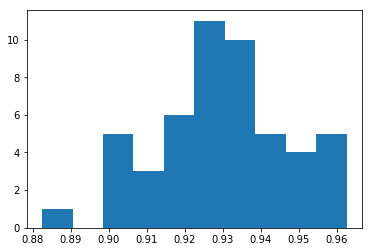

In [62]:
# plot scores
from matplotlib import pyplot
pyplot.hist(scores)
pyplot.show()

In [63]:
# Random Forest Model - train & test
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(min_samples_split=60)
model.fit(docterm_train, y_train)

# evaluate model
evaluate_model(model.predict, docterm_train, y_train, docterm_test, y_test)

Training Accuracy:  94.00%
Testing Accuracy:  82.00%


In [64]:
# Random Forest Model - accuracy confidence interval & average accuracy

lb, ub, ave_acc, scores = bootstrap_conf(model.fit, 
                                         model.predict, 
                                         data, 
                                         '_label_', 
                                         N_ITERATIONS, 
                                         ALPHA)
print('{:.2f}% confidence interval {:.2f}% and {:.2f}%'.format(ALPHA*100, lb*100, ub*100))
print("Average accuracy: {:.2f}%".format(ave_acc*100))

Computing bootstrap samples: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
95.00% confidence interval 84.61% and 92.25%
Average accuracy: 88.43%


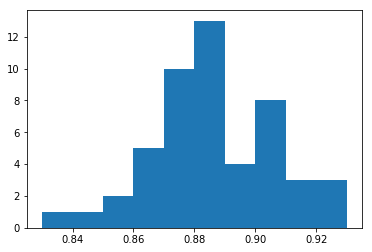

In [65]:
# plot scores
from matplotlib import pyplot
pyplot.hist(scores)
pyplot.show()

In [ ]:
# DNN
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout

# build the model
model = Sequential()
model.add(Dense(1024, input_dim=docterm_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [74]:
model.fit(docterm_train, y_train.apply(convert),
          epochs=5,
          batch_size=128,
          validation_data=(docterm_test, y_test.apply(convert)))

Epoch 1/5
1600/1600 [==============================] - 14s 9ms/step - loss: 0.7360 - acc: 0.5219
Epoch 2/5
1600/1600 [==============================] - 12s 7ms/step - loss: 0.5886 - acc: 0.6975
Epoch 3/5
1600/1600 [==============================] - 11s 7ms/step - loss: 0.3645 - acc: 0.8675
Epoch 4/5
1600/1600 [==============================] - 11s 7ms/step - loss: 0.1668 - acc: 0.9569
Epoch 5/5
1600/1600 [==============================] - 12s 8ms/step - loss: 0.0424 - acc: 0.9919


In [75]:
# evaluate model

evaluate_model(model.predict_classes, docterm_train, y_train.apply(convert), docterm_test, y_test.apply(convert))

Training Accuracy:  99.75%
Testing Accuracy:  91.25%


In [77]:
# DNN - accuracy confidence interval & average accuracy

def dnn_model_fit(X, y):
    model.fit(X, 
              y,
              epochs=5,
              batch_size=128,
              verbose=0)

lb, ub, ave_acc, scores = bootstrap_conf(dnn_model_fit, 
                                         model.predict_classes, 
                                         dnn_data, 
                                         '_label_', 
                                         N_ITERATIONS, 
                                         ALPHA)
print('{:.2f}% confidence interval {:.2f}% and {:.2f}%'.format(ALPHA*100, lb*100, ub*100))
print("Average accuracy: {:.2f}%".format(ave_acc*100))

Computing bootstrap samples: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
95.00% confidence interval 99.75% and 100.00%
Average accuracy: 99.95%


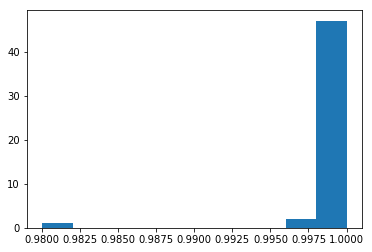

In [78]:
# plot scores
from matplotlib import pyplot
pyplot.hist(scores)
pyplot.show()

## Semantic Features

In [80]:
# Load Spacy semantic model

import spacy

EMBEDDING_DIM = 300

# NOTE: for performance reasons disable everything in the pipeline except the tokenizer
nlp = spacy.load('en_core_web_lg', disable=['parser', 'tagger', 'ner', 'textcat'])

In [81]:
# preprocess text for semantic features

def embed(X):
    '''
    x is a list of strings and embed will compute
    an embedding vector for each and return an array
    of shape (len(x),EMBEDDING_DIM)
    '''
    vectors = []
    text_array = np.array(X)

    print(text_array.shape)
    
    for i in range(text_array.shape[0]):
        vector = nlp(text_array[i]).vector
        vectors.append(vector)
    
    return pd.DataFrame(vectors)

vectors = embed(X)

(2000,)


In [82]:
# create training and test data
from sklearn.model_selection import train_test_split
vectors_train, vectors_test, y_train, y_test = train_test_split(vectors, 
                                                                y.apply(convert), 
                                                                test_size=TEST_SIZE)

In [84]:
# data for accuracy confidence interval and average accuracy

data = vectors.copy()
data['_label_'] = y.values

# dnn data has to be all numerical
dnn_data = vectors.copy()
dnn_data['_label_'] = y.apply(convert).values

In [85]:
# Naive Bayes Model 
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(vectors_train,y_train)

# evaluate model
evaluate_model(model.predict, vectors_train, y_train, vectors_test, y_test)

Training Accuracy:  71.25%
Testing Accuracy:  72.00%


In [86]:
# Naive Bayes Model - accuracy confidence interval & average accuracy

lb, ub, ave_acc, scores = bootstrap_conf(model.fit, 
                                         model.predict, 
                                         data, 
                                         '_label_', 
                                         N_ITERATIONS, 
                                         ALPHA)
print('{:.2f}% confidence interval {:.2f}% and {:.2f}%'.format(ALPHA*100, lb*100, ub*100))
print("Average accuracy: {:.2f}%".format(ave_acc*100))

Computing bootstrap samples: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
95.00% confidence interval 66.97% and 76.39%
Average accuracy: 71.29%


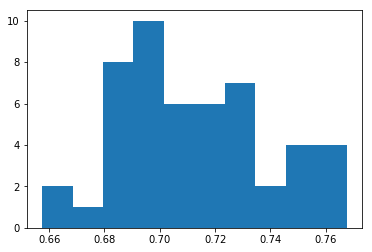

In [87]:
# plot scores
from matplotlib import pyplot
pyplot.hist(scores)
pyplot.show()

In [89]:
# Random Forest Model 
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(min_samples_split=10)
model.fit(vectors_train, y_train)

# evaluate model
evaluate_model(model.predict, vectors_train, y_train, vectors_test, y_test)

Training Accuracy:  98.12%
Testing Accuracy:  86.25%


In [90]:
# Random Forest Model - accuracy confidence interval & average accuracy

lb, ub, ave_acc, scores = bootstrap_conf(model.fit, 
                                         model.predict, 
                                         data, 
                                         '_label_', 
                                         N_ITERATIONS, 
                                         ALPHA)
print('{:.2f}% confidence interval {:.2f}% and {:.2f}%'.format(ALPHA*100, lb*100, ub*100))
print("Average accuracy: {:.2f}%".format(ave_acc*100))

Computing bootstrap samples: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
95.00% confidence interval 86.39% and 92.94%
Average accuracy: 90.55%


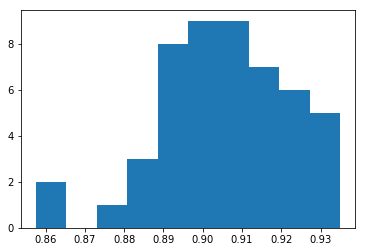

In [91]:
# plot scores
from matplotlib import pyplot
pyplot.hist(scores)
pyplot.show()

In [94]:
# DNN - MLP
from keras.models import Sequential
from keras.layers import Dense, Dropout

# build the model
model = Sequential()
model.add(Dense(256, input_dim=EMBEDDING_DIM, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit(vectors_train, y_train,
          epochs=15,
          batch_size=128,
          validation_data=(vectors_test, y_test))

Train on 1600 samples, validate on 400 samples
Epoch 1/15
1600/1600 [==============================] - 3s 2ms/step - loss: 0.6977 - acc: 0.5131 - val_loss: 0.6860 - val_acc: 0.4925
Epoch 2/15
1600/1600 [==============================] - 0s 213us/step - loss: 0.6866 - acc: 0.5394 - val_loss: 0.6657 - val_acc: 0.7250
Epoch 3/15
1600/1600 [==============================] - 0s 211us/step - loss: 0.6640 - acc: 0.5931 - val_loss: 0.6179 - val_acc: 0.7100
Epoch 4/15
1600/1600 [==============================] - 0s 250us/step - loss: 0.6262 - acc: 0.6569 - val_loss: 0.5178 - val_acc: 0.7875
Epoch 5/15
1600/1600 [==============================] - 0s 267us/step - loss: 0.5607 - acc: 0.7281 - val_loss: 0.4491 - val_acc: 0.8150
Epoch 6/15
1600/1600 [==============================] - 0s 208us/step - loss: 0.5024 - acc: 0.7744 - val_loss: 0.4001 - val_acc: 0.8350
Epoch 7/15
1600/1600 [==============================] - 0s 256us/step - loss: 0.4662 - acc: 0.7925 - val_loss: 0.3704 - val_acc: 0.8475
Epo

In [95]:
# evaluate model

evaluate_model(model.predict_classes, vectors_train, y_train, vectors_test, y_test)

Training Accuracy:  89.44%
Testing Accuracy:  91.00%


In [96]:
# DNN - accuracy confidence interval & average accuracy

def dnn_model_fit(X, y):
    model.fit(X, 
              y,
              epochs=15,
              batch_size=128,
              verbose=0)

lb, ub, ave_acc, scores = bootstrap_conf(dnn_model_fit, 
                                         model.predict_classes, 
                                         dnn_data, 
                                         '_label_', 
                                         N_ITERATIONS, 
                                         ALPHA)
print('{:.2f}% confidence interval {:.2f}% and {:.2f}%'.format(ALPHA*100, lb*100, ub*100))
print("Average accuracy: {:.2f}%".format(ave_acc*100))

Computing bootstrap samples: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
95.00% confidence interval 90.81% and 100.00%
Average accuracy: 98.38%


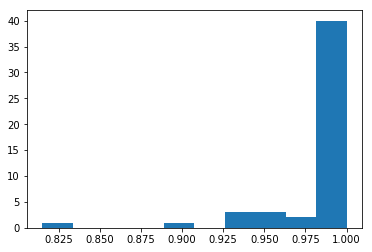

In [97]:
# plot scores
from matplotlib import pyplot
pyplot.hist(scores)
pyplot.show()